## Importing Libraries

In [1]:
!pip3 install pubchempy
!pip3 install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pubchempy as pcp
import pandas as pd
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn import tree
import graphviz
from sklearn.model_selection import GridSearchCV
from imblearn.metrics import geometric_mean_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.metrics import matthews_corrcoef
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from rdkit import Chem
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
import copy
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras

# Apply the default theme
sns.set_theme()

warnings.filterwarnings("ignore")

## Getting Data Using APIs

In [3]:
df = pd.read_csv('/content/Assay List CCTE_Padilla_ZF_144hpf_TERATOSCORE_up-2022-11-07 (2).csv')

In [4]:
print("Number of inactive cases is: ", df.where(df["HIT CALL"] == "Inactive").count()[0])
print("Number of active cases is: ", df.where(df["HIT CALL"] == "Active").count()[0])

Number of inactive cases is:  223
Number of active cases is:  497


In [5]:
df.isnull().any()

DTXSID               False
PREFERRED NAME       False
CASRN                False
MOLECULAR FORMULA     True
MONOISOTOPIC MASS    False
ToxCast Active       False
ToxCast Total        False
% ToxCast Active     False
HIT CALL             False
TOP                   True
SCALED TOP            True
AC50                  True
LOGAC50               True
dtype: bool

In [6]:
df = df.drop(columns=["ToxCast Active", "ToxCast Total", "% ToxCast Active", "CASRN", "TOP", "SCALED TOP", "LOGAC50", "AC50", "DTXSID", 'MOLECULAR FORMULA', 'MONOISOTOPIC MASS'])

In [7]:
df.dropna(inplace=True)
df.head(3)

,PREFERRED NAME,HIT CALL
0,Sodium L-ascorbate,Active
1,Chlorothalonil,Active
2,Acifluorfen,Inactive


In [8]:
compounds = []
for i in df["PREFERRED NAME"]:
  try:
    compounds.append(pcp.get_compounds(i, 'name'))
    time.sleep(0.1)
  except TypeError or URLError:
    print(i)

In [9]:
df['compounds'] = compounds
df.head(3)

,PREFERRED NAME,HIT CALL,compounds
0,Sodium L-ascorbate,Active,[Compound(23667548)]
1,Chlorothalonil,Active,[Compound(15910)]
2,Acifluorfen,Inactive,[Compound(44073)]


In [10]:
df = df.where(df["compounds"].str.len() == 1).dropna()

In [11]:
for index, row in df.iterrows():
  c = row["compounds"][0]
  df.loc[index, 'Hydrogen_Bond_Donor_Count'] = c.h_bond_donor_count
  df.loc[index, 'Hydrogen_Bond_Acceptor_Count'] = c.h_bond_acceptor_count
  df.loc[index, 'Formal_Charge'] = c.charge
  df.loc[index, 'Mw'] = c.molecular_weight
  df.loc[index, 'canonical_smiles'] = c.canonical_smiles
  df.loc[index, 'xlogp'] = c.xlogp
  df.loc[index, 'exact_mass'] = c.exact_mass

In [12]:
df = df.drop(columns=['Formal_Charge'])

In [13]:
mols = []
df.dropna()
from rdkit.Chem import AllChem, MACCSkeys, Descriptors
for smiles in df["canonical_smiles"]:
  mol = Chem.MolFromSmiles(smiles)
  mols.append(mol)

df["mol"] = mols

for index, row in df.iterrows():
  mol = row["mol"]
  df.loc[index,'NumHeteroatoms'] = Descriptors.NumHeteroatoms(mol)
  df.loc[index,'NumRotatableBonds'] = Descriptors.NumRotatableBonds(mol)
  df.loc[index,'NumHeavyAtoms'] = Descriptors.HeavyAtomCount (mol)
  df.loc[index,'NumAliphaticCarbocycles'] = Descriptors.NumAliphaticCarbocycles(mol)
  df.loc[index,'NumAliphaticHeterocycles'] = Descriptors.NumAliphaticHeterocycles(mol)
  df.loc[index,'NumAliphaticRings'] = Descriptors.NumAliphaticRings(mol)
  df.loc[index,'NumAromaticCarbocycles'] = Descriptors.NumAromaticCarbocycles(mol)
  df.loc[index,'NumAromaticHeterocycles'] = Descriptors.NumAromaticHeterocycles(mol)
  df.loc[index,'NumAromaticRings'] = Descriptors.NumAromaticRings(mol)
  df.loc[index,'RingCount'] = Descriptors.RingCount(mol)
  df.loc[index,'FractionCSP3'] = Descriptors.FractionCSP3(mol)
  df.loc[index,'NHOHCount'] = Descriptors.NHOHCount(mol)
  df.loc[index,'NOCount'] = Descriptors.NOCount(mol)
  df.loc[index,'NumValenceElectrons'] = Descriptors.NumValenceElectrons(mol)
  df.loc[index,'TPSA'] = Descriptors.TPSA(mol)

In [14]:
df.dropna(inplace=True)
df.head(3)

,PREFERRED NAME,HIT CALL,compounds,Hydrogen_Bond_Donor_Count,Hydrogen_Bond_Acceptor_Count,Mw,canonical_smiles,xlogp,exact_mass,mol,...,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,RingCount,FractionCSP3,NHOHCount,NOCount,NumValenceElectrons,TPSA
1,Chlorothalonil,Active,[Compound(15910)],0.0,2.0,265.9,C(#N)C1=C(C(=C(C(=C1Cl)Cl)Cl)C#N)Cl,2.9,265.878609,<rdkit.Chem.rdchem.Mol object at 0x7f2db4b067a0>,...,0.0,1.0,0.0,1.0,1.0,0.000000,0.0,2.0,70.0,47.58
2,Acifluorfen,Inactive,[Compound(44073)],1.0,8.0,361.65,C1=CC(=C(C=C1C(F)(F)F)Cl)OC2=CC(=C(C=C2)[N+](=...,3.0,360.9964845,<rdkit.Chem.rdchem.Mol object at 0x7f2db4b06810>,...,0.0,2.0,0.0,2.0,2.0,0.071429,1.0,6.0,126.0,89.67
3,Dichlorprop,Active,[Compound(8427)],1.0,3.0,235.06,CC(C(=O)O)OC1=C(C=C(C=C1)Cl)Cl,3.4,233.9850495,<rdkit.Chem.rdchem.Mol object at 0x7f2db4b06880>,...,0.0,1.0,0.0,1.0,1.0,0.222222,1.0,3.0,76.0,46.53


In [15]:
print("Number of inactive cases is: \t", df.where(df["HIT CALL"] == "Inactive").dropna().count()[0])
print("Number of active cases is: \t", df.where(df["HIT CALL"] == "Active").dropna().count()[0])

Number of inactive cases is: 	 180
Number of active cases is: 	 419


## Cleaning Data and Data Visualization

In [16]:
df['Mw'] = df['Mw'].map(lambda x: float(x))
df['exact_mass'] = df['exact_mass'].map(lambda x: float(x))

In [17]:
features = ['Hydrogen_Bond_Donor_Count',
 'Hydrogen_Bond_Acceptor_Count',
 'Mw',
 'xlogp',
 'NumHeteroatoms',
 'NumRotatableBonds',
 'NumHeavyAtoms',
 'NumAliphaticCarbocycles',
 'NumAliphaticHeterocycles',
 'NumAliphaticRings',
 'NumAromaticCarbocycles',
 'NumAromaticHeterocycles',
 'NumAromaticRings',
 'RingCount',
 'FractionCSP3',
 'NHOHCount',
 'NOCount',
 'NumValenceElectrons',
 'TPSA']

In [18]:
df.to_csv("final_output.csv")

In [19]:
for f in features:
  print(f, " stdv: \t\t\t\t", df[f].std())

Hydrogen_Bond_Donor_Count  stdv: 				 0.9548754912909894
Hydrogen_Bond_Acceptor_Count  stdv: 				 3.197657377257603
Mw  stdv: 				 110.91725459532307
xlogp  stdv: 				 1.9201806152635676
NumHeteroatoms  stdv: 				 3.6037041348365144
NumRotatableBonds  stdv: 				 3.387913718457272
NumHeavyAtoms  stdv: 				 7.4034248149807045
NumAliphaticCarbocycles  stdv: 				 0.8442047567005193
NumAliphaticHeterocycles  stdv: 				 0.5050871576056263
NumAliphaticRings  stdv: 				 1.0130058037065028
NumAromaticCarbocycles  stdv: 				 0.882604455801867
NumAromaticHeterocycles  stdv: 				 0.5366246434954842
NumAromaticRings  stdv: 				 1.026766146693579
RingCount  stdv: 				 1.2809896349348304
FractionCSP3  stdv: 				 0.30732501424661385
NHOHCount  stdv: 				 1.104745308796405
NOCount  stdv: 				 2.4337337924990248
NumValenceElectrons  stdv: 				 39.526134918846836
TPSA  stdv: 				 32.59856799054863


In [20]:
df['Mw'].corr(df['exact_mass'])

0.9999936755538242

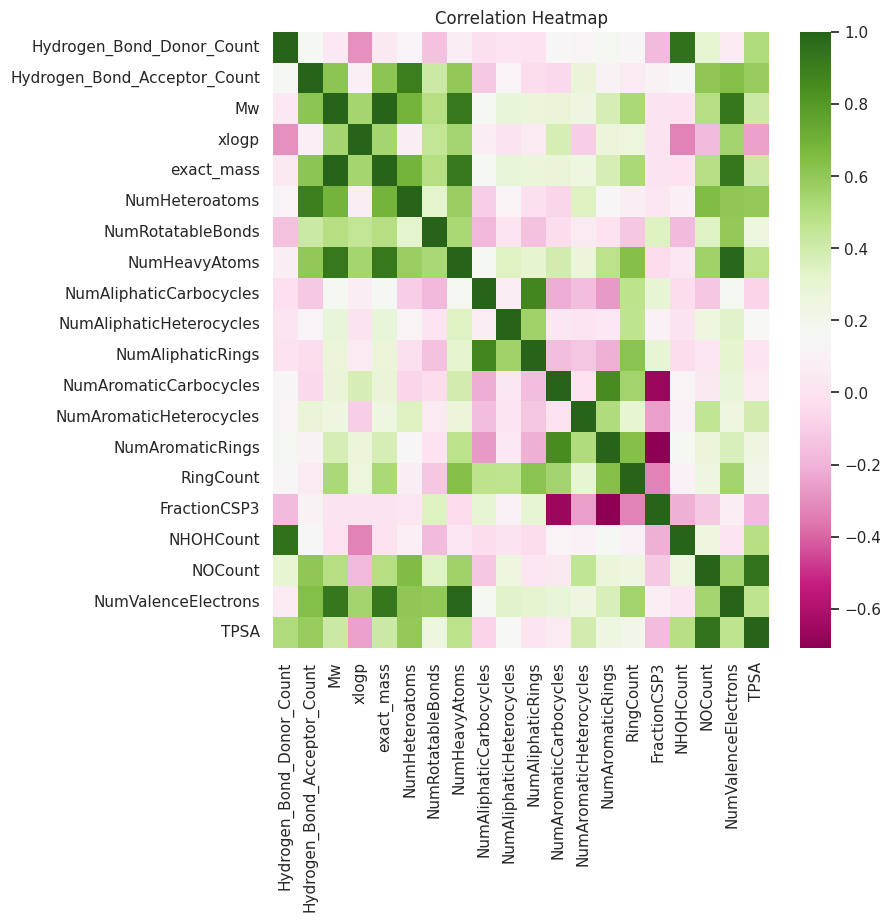

In [21]:
corr_matrix = df.corr()

fig, ax = plt.subplots(figsize=(8,8))
sns.color_palette("PiYG", as_cmap=True)
sns.heatmap(corr_matrix, cmap = "PiYG")
plt.title('Correlation Heatmap')
plt.show()

In [22]:
df = df.drop(columns=['PREFERRED NAME', 'mol', 'canonical_smiles', 'compounds', 'exact_mass'])

In [23]:
df.to_csv("final_output.csv")

In [24]:
numerical_features = [
    'NumHeteroatoms', 'NumValenceElectrons', 'NOCount', 'Hydrogen_Bond_Acceptor_Count', 'NumAromaticRings', 'NHOHCount', 'RingCount', 'NumAliphaticRings',
    'NumAromaticHeterocycles', 'NumAromaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticCarbocycles', 'NumHeavyAtoms', 'NumRotatableBonds'
]

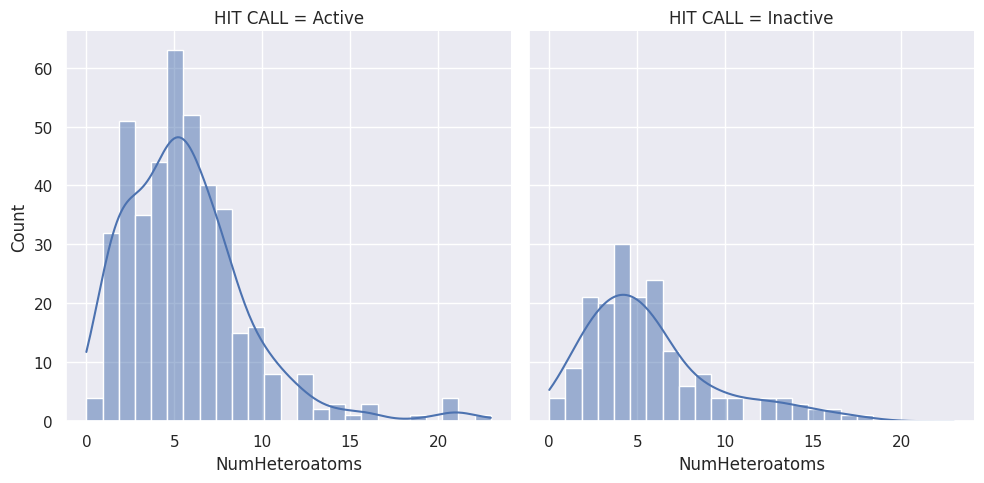

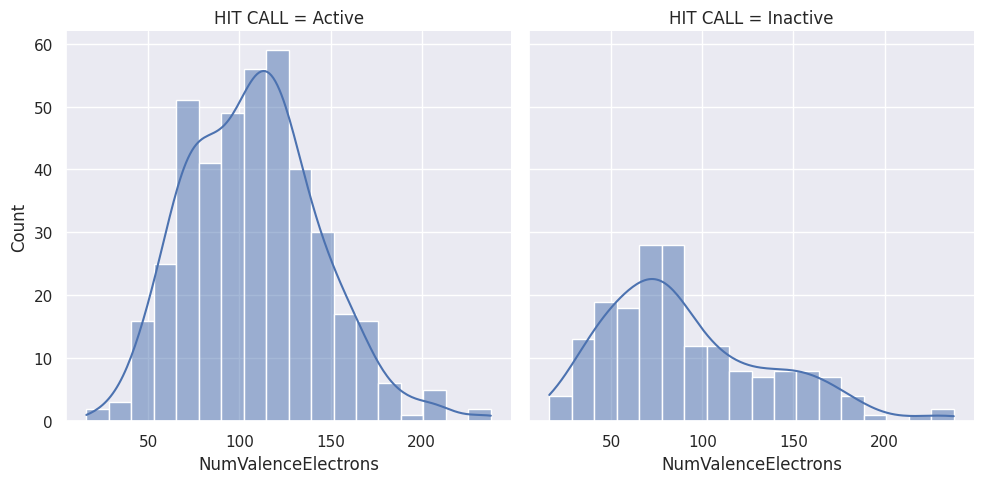

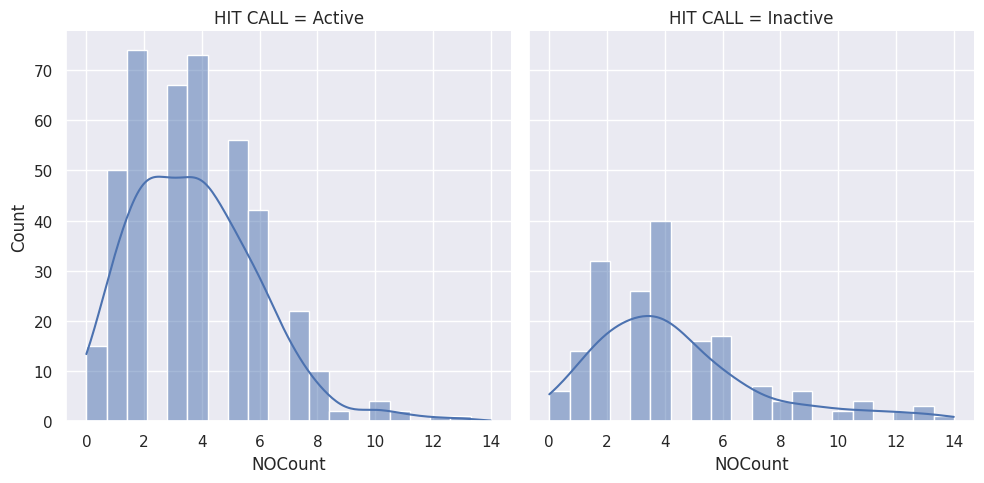

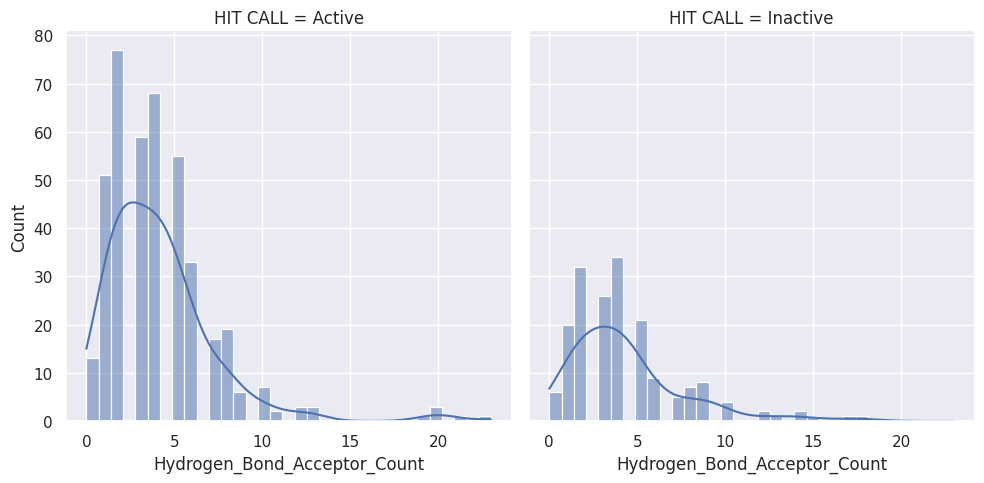

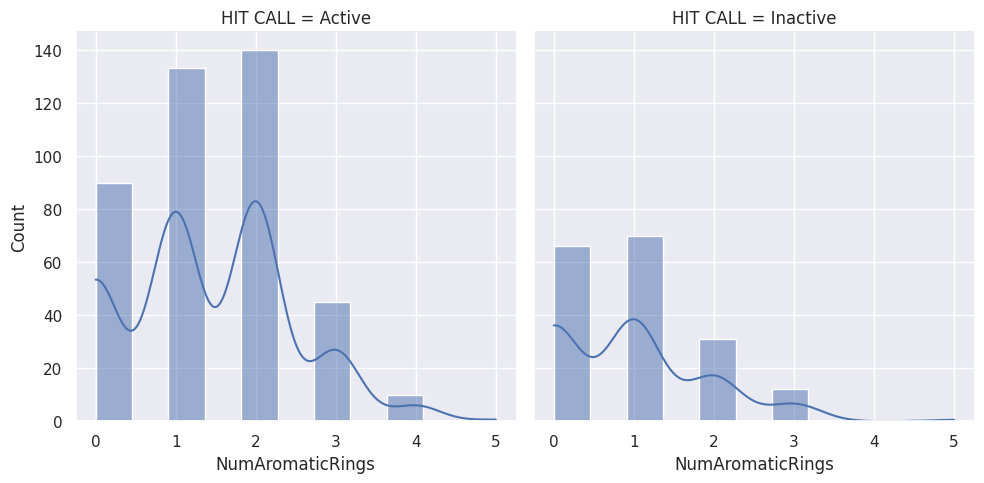

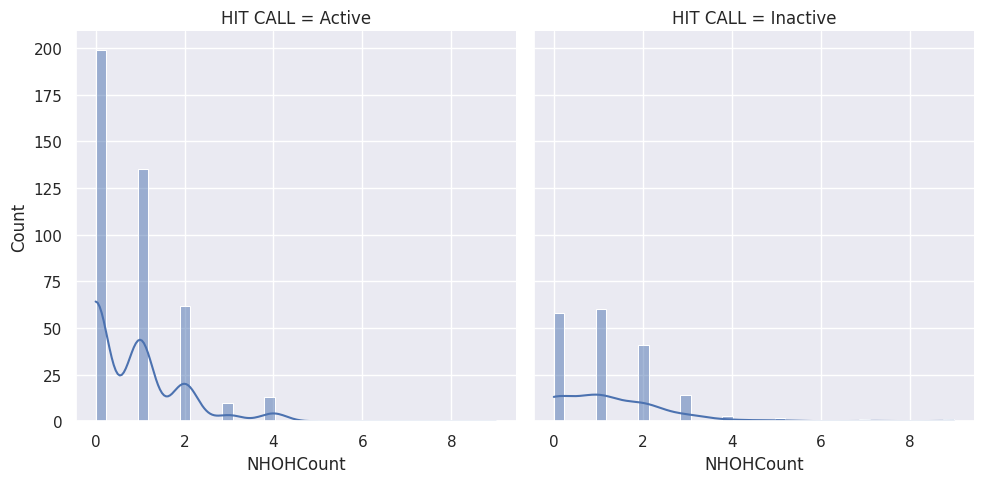

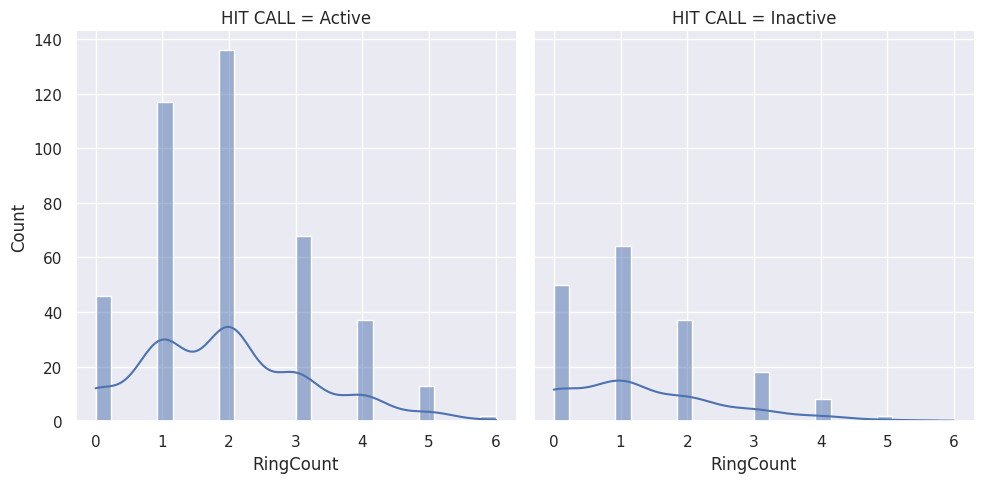

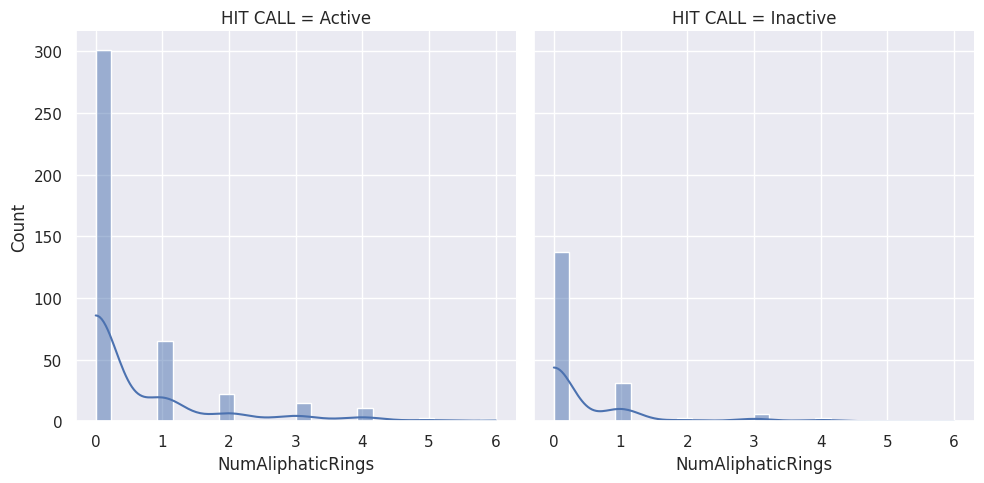

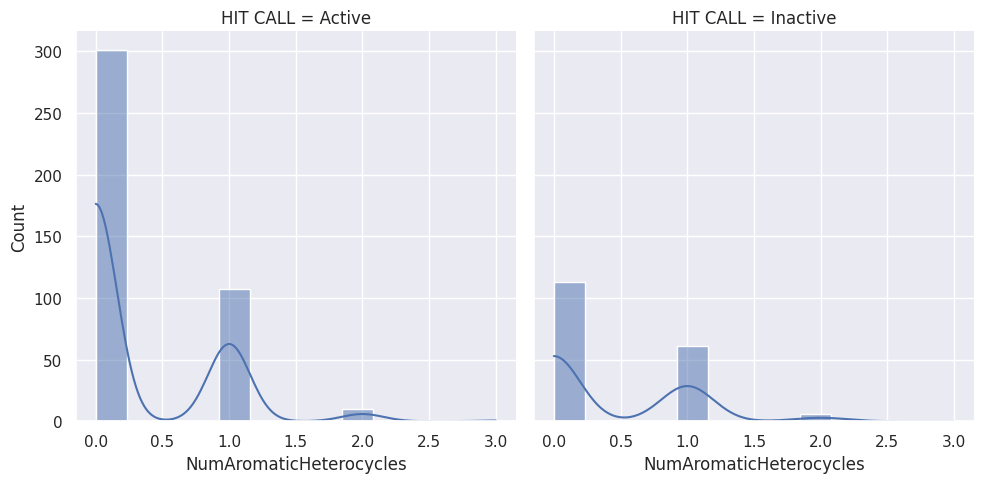

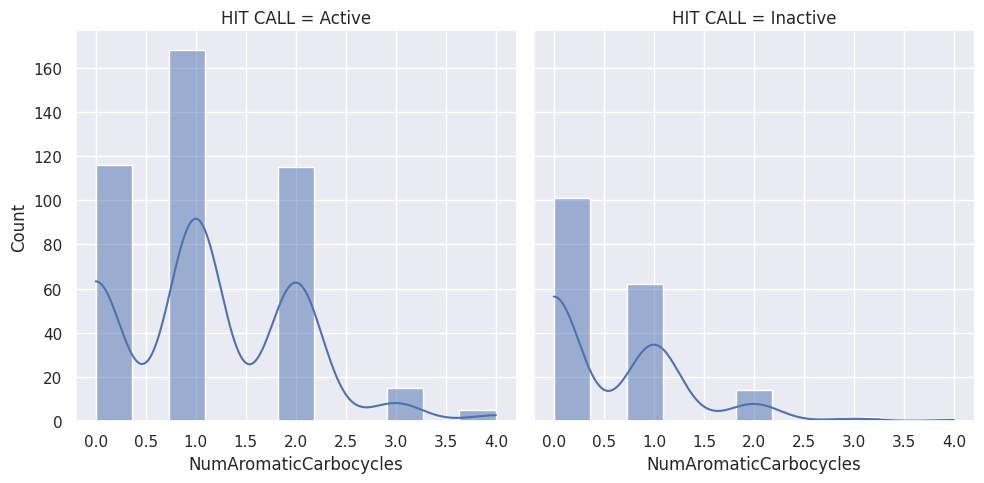

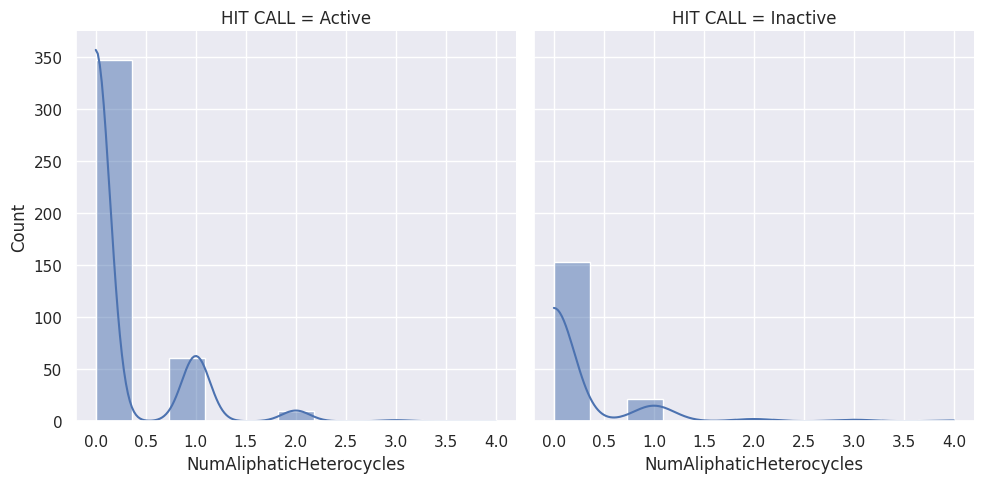

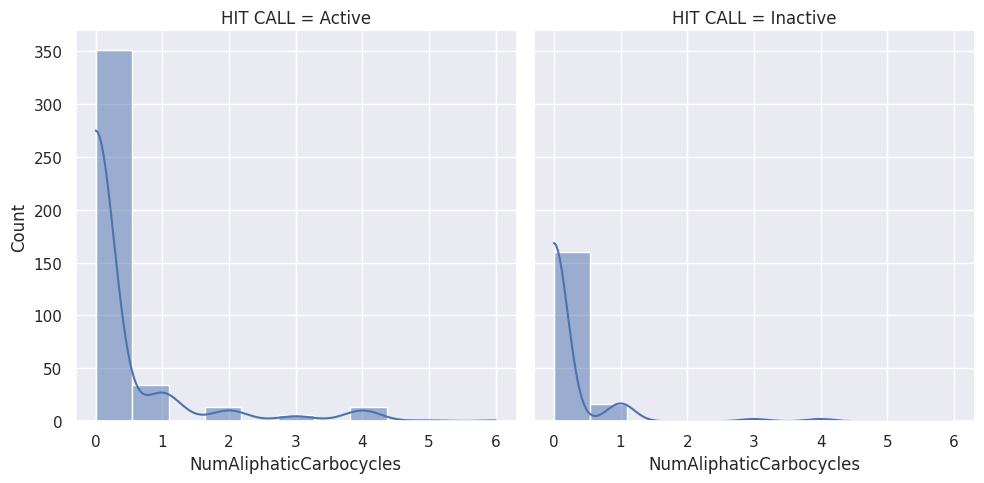

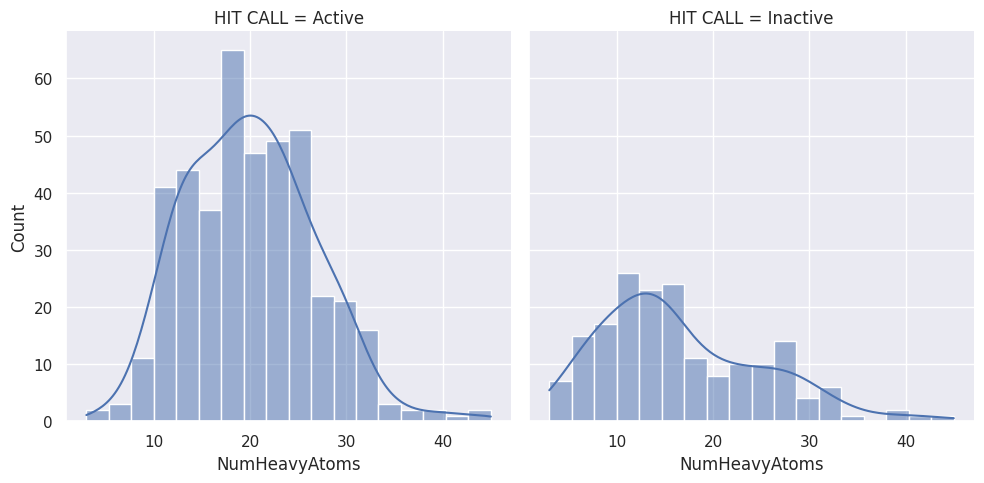

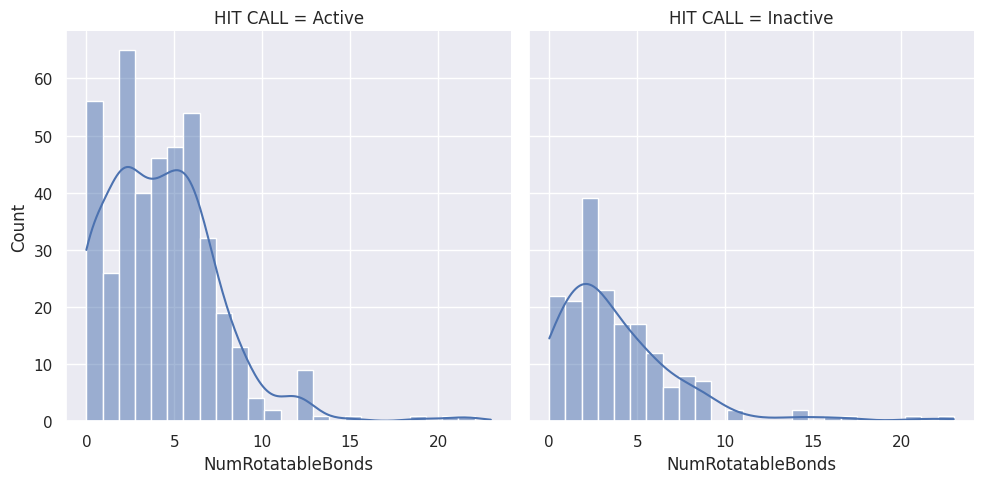

In [25]:
for f in numerical_features:
  sns.displot(data=df, x=f, col="HIT CALL", kde=True)

## Feature Engineering

In [26]:
def has_feature(feature):
  if feature > 0:
    return 1
  else:
    return 0

In [27]:
new_features = []
for f in numerical_features:
  new_name = "Has"
  if 'Count' in f:
    new_name = f.replace("Count", "")
  elif 'Num' in f:
    new_name = f.replace("Num", "")
  new_features.append(new_name)
  df[new_name] = df[f].apply(has_feature)

In [28]:
total_features = new_features + features

In [29]:
X = df[total_features]
y = df["HIT CALL"]

y = y.replace("Active", 1)
y = y.replace("Inactive", 0)

In [30]:
scaler = StandardScaler()
stand_X = copy.deepcopy(X)
stand_X[features] = scaler.fit_transform(X[features])
stand_X = pd.DataFrame(stand_X, index=X.index, columns=X.columns)

In [31]:
X_train_stand, X_test_stand, y_train_stand, y_test_stand = train_test_split(stand_X, y, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [32]:
df.to_csv('final_output.csv')

## Feature Selection

### ANOVA (Analysis of Variance)

In [33]:
f_values, p_values = f_classif(X_train_stand, y_train_stand)

# Create a DataFrame with feature scores and p-values
scores_df = pd.DataFrame({'Feature': X_train_stand.columns, 'F-Score': f_values, 'p-value': p_values})

# Sort the features by F-Score in descending order
scores_df = scores_df.sort_values(by='F-Score', ascending=False)

# Print the sorted DataFrame
print(scores_df)

                         Feature     F-Score       p-value
17                         xlogp  106.439908  2.229234e-22
24        NumAromaticCarbocycles   43.983140  1.029248e-10
9            AromaticCarbocycles   40.446141  5.317740e-10
27                     RingCount   35.089437  6.594376e-09
16                            Mw   32.524085  2.232832e-08
20                 NumHeavyAtoms   32.325021  2.455438e-08
31           NumValenceElectrons   27.652477  2.324732e-07
26              NumAromaticRings   26.303214  4.477925e-07
6                           Ring   18.503199  2.115010e-05
14     Hydrogen_Bond_Donor_Count   14.892804  1.318226e-04
4                  AromaticRings   12.235141  5.194079e-04
29                     NHOHCount   11.233965  8.763858e-04
28                  FractionCSP3    8.412422  3.923839e-03
32                          TPSA    7.438481  6.653913e-03
5                           NHOH    6.298553  1.246164e-02
21       NumAliphaticCarbocycles    5.331196  2.143512e-

### Desicion Tree

In [34]:
tree_clf = ExtraTreesClassifier()
tree_clf = tree_clf.fit(X_train, y_train)

In [35]:
tree_feature_selection = pd.DataFrame({"features": X_train.columns.to_list(), "Importance": tree_clf.feature_importances_.tolist()}).sort_values(by="Importance", ascending=False)
print(tree_feature_selection)

                        features  Importance
17                         xlogp    0.127660
16                            Mw    0.080027
20                 NumHeavyAtoms    0.073883
31           NumValenceElectrons    0.068430
19             NumRotatableBonds    0.062673
28                  FractionCSP3    0.059478
32                          TPSA    0.057088
18                NumHeteroatoms    0.054047
15  Hydrogen_Bond_Acceptor_Count    0.047147
30                       NOCount    0.045373
9            AromaticCarbocycles    0.036573
29                     NHOHCount    0.032833
24        NumAromaticCarbocycles    0.030262
14     Hydrogen_Bond_Donor_Count    0.029968
27                     RingCount    0.028629
5                           NHOH    0.022134
26              NumAromaticRings    0.017604
13                RotatableBonds    0.013857
23             NumAliphaticRings    0.013473
21       NumAliphaticCarbocycles    0.012095
25       NumAromaticHeterocycles    0.012086
8         

In [36]:
tree_features = tree_feature_selection.where(tree_feature_selection["Importance"] > 0.050).dropna()['features'].to_list()

### L2 Feature Selection

In [37]:
lr = LinearSVC(C=1, penalty="l2").fit(X_train_stand, y_train_stand)
sel = SelectFromModel(lr, prefit=True)

In [38]:
SVC_feature_selection = pd.DataFrame({"features": X_train.columns.to_list(), "Importance": sel.get_support().tolist()})
print(SVC_feature_selection.sort_values(by="Importance", ascending=False))

                        features  Importance
0                    Heteroatoms        True
10         AliphaticHeterocycles        True
31           NumValenceElectrons        True
30                       NOCount        True
29                     NHOHCount        True
20                 NumHeavyAtoms        True
18                NumHeteroatoms        True
17                         xlogp        True
15  Hydrogen_Bond_Acceptor_Count        True
14     Hydrogen_Bond_Donor_Count        True
16                            Mw        True
32                          TPSA        True
9            AromaticCarbocycles        True
8           AromaticHeterocycles        True
3        Hydrogen_Bond_Acceptor_        True
6                           Ring        True
24        NumAromaticCarbocycles       False
2                             NO       False
4                  AromaticRings       False
28                  FractionCSP3       False
27                     RingCount       False
26        

In [39]:
L2_features = SVC_feature_selection.where(SVC_feature_selection["Importance"] == True).dropna()['features'].to_list()

## Building Models

### Using Class Weightening

In [40]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)

gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train, y_train, sample_weight = list(map(lambda x: class_weights[1] if x == 1 else class_weights[0], y_train)))
y_pred = gb_classifier.predict(X_test)
mcc_score = matthews_corrcoef(y_test, y_pred)

print("MCC score on the test set: {:.2f}".format(mcc_score))

MCC score on the test set: 0.46


### Oversampling

In [41]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

print(y_sm.value_counts())

1    419
0    419
Name: HIT CALL, dtype: int64


In [42]:
smote = SMOTE(sampling_strategy='minority')
stand_X_sm, stand_y_sm = smote.fit_resample(stand_X, y)

stand_y_sm.value_counts()

1    419
0    419
Name: HIT CALL, dtype: int64

In [43]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size=0.3, random_state=42)
stand_X_train_sm, stand_X_test_sm, stand_y_train_sm, stand_y_test_sm = train_test_split(stand_X_sm, stand_y_sm, test_size=0.3, random_state=42)

### Adding Cross Validation

#### Functions

In [44]:
results = pd.DataFrame(columns=['Name', 'MCC', 'Selected_Features', 'Size'])

def GradientBoostingClassifier_function(selected_features=total_features):
  # class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)
  # print("class_weights: ", class_weights)

  gb_classifier = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, max_depth=3)

  '''
  We ran this part of code once to find the best parameters, then we used them in the previous line

  model = GradientBoostingClassifier()
  param_grid = {
      'n_estimators': [50, 100, 200],
      'learning_rate': [0.1, 0.05, 0.01],
      'max_depth': [3, 4, 5]
  }

  # Perform grid search with cross-validation
  gb_classifier = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
  gb_classifier.fit(X_train_sm, y_train_sm)

  # Print the best hyperparameters and the corresponding accuracy score
  print('Best hyperparameters:', gb_classifier.best_params_)

  '''

  kf = KFold(n_splits=5, shuffle=True, random_state=42)
  scores = np.zeros(5)

  for i, (train_index, test_index) in enumerate(kf.split(X_train_sm[selected_features])):
      X_train_fk, X_test_fk = X_train_sm[selected_features].iloc[train_index], X_train_sm[selected_features].iloc[test_index]
      y_train_fk, y_test_fk = y_train_sm.iloc[train_index], y_train_sm.iloc[test_index]

      # Fit the model on the training data
      # gb_classifier.fit(X_train_fk, y_train_fk, sample_weight=list(map(lambda x: class_weights[1] if x == 1 else class_weights[0], y_train_fk)))
      gb_classifier.fit(X_train_fk, y_train_fk)

      # Calculate the score on the test data and store it
      score = gb_classifier.score(X_test_fk, y_test_fk)
      scores[i] = score

  # Print the cross-validation scores and the average score
  # print("Cross-validation scores:", scores)
  # print("Average score:", np.mean(scores))

  y_pred = gb_classifier.predict(X_test_sm[selected_features])
  mcc_score = matthews_corrcoef(y_test_sm, y_pred)

  print("MCC score on the test set for GradientBoostingClassifier is: {:.2f}".format(mcc_score))
  record = {'Name': 'GradientBoosting', 'MCC': "{:.2f}".format(mcc_score), 'Selected_Features': total_features, 'Size':len(total_features)}
  results.loc[len(results)] = record

In [45]:
def KNN_function(selected_features=total_features):

  knn_classifier = KNeighborsClassifier(n_neighbors=5, metric='manhattan', algorithm='auto')

  '''
  model = KNeighborsClassifier()
  param_grid = {'n_neighbors': [3, 5, 7, 9],
              'metric': ['manhattan', 'euclidean', 'cosine', 'minkowski'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
              }

  # Perform grid search with cross-validation
  knn_classifier = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
  knn_classifier.fit(X_train_sm, y_train_sm)

  # Print the best hyperparameters and the corresponding accuracy score
  print('Best hyperparameters:', knn_classifier.best_params_)
  '''

  kf = KFold(n_splits=5, shuffle=True, random_state=42)
  scores = np.zeros(5)

  for i, (train_index, test_index) in enumerate(kf.split(stand_X_train_sm[selected_features])):
      X_train_fk, X_test_fk = stand_X_train_sm[selected_features].iloc[train_index], stand_X_train_sm[selected_features].iloc[test_index]
      y_train_fk, y_test_fk = y_train_sm.iloc[train_index], y_train_sm.iloc[test_index]

      knn_classifier.fit(X_train_fk, y_train_fk)

      score = knn_classifier.score(X_test_fk, y_test_fk)
      scores[i] = score

  y_pred = knn_classifier.predict(stand_X_test_sm[selected_features])
  mcc_score = matthews_corrcoef(y_test_sm, y_pred)

  print("MCC score on the test set for KNNClassifier is: {:.2f}".format(mcc_score))
  record = {'Name': 'KNN', 'MCC': "{:.2f}".format(mcc_score), 'Selected_Features': total_features, 'Size':len(total_features)}
  results.loc[len(results)] = record

In [46]:
def LogisticRegression_function(selected_features=total_features):

  lr_classifier = LogisticRegression(C=1, penalty='l1', solver='liblinear')

  '''
  model = LogisticRegression()
  # Define the parameter grid
  param_grid = {
      'penalty': ['l1', 'l2', 'elasticnet', 'none'],
      'C': [0.1, 1, 10],
      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
  }

  # Perform grid search with cross-validation
  lr_classifier = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
  lr_classifier.fit(X_train_sm, y_train_sm)

  # Print the best hyperparameters and the corresponding accuracy score
  print('Best hyperparameters:', lr_classifier.best_params_)
  '''

  kf = KFold(n_splits=5, shuffle=True, random_state=42)
  scores = np.zeros(5)

  for i, (train_index, test_index) in enumerate(kf.split(X_train_sm[selected_features])):
      X_train_fk, X_test_fk = X_train_sm[selected_features].iloc[train_index], X_train_sm[selected_features].iloc[test_index]
      y_train_fk, y_test_fk = y_train_sm.iloc[train_index], y_train_sm.iloc[test_index]

      lr_classifier.fit(X_train_fk, y_train_fk)

      score = lr_classifier.score(X_test_fk, y_test_fk)
      scores[i] = score

  y_pred = lr_classifier.predict(X_test_sm[selected_features])
  mcc_score = matthews_corrcoef(y_test_sm, y_pred)

  print("MCC score on the test set for LogisticRegression is: {:.2f}".format(mcc_score))
  record = {'Name': 'LogisticRegression', 'MCC': "{:.2f}".format(mcc_score), 'Selected_Features': total_features, 'Size':len(total_features)}
  results.loc[len(results)] = record

In [47]:
from math import sqrt
def mcc(tp, fp, tn, fn):
    x = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return ((tp * tn) - (fp * fn)) / sqrt(x)

In [48]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_loss(history, epochs=100):
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  # train_accuracy = history.history['accuracy']
  # val_accuracy = history.history['val_accuracy']

  # Plot the learning curve
  plt.figure(figsize=(8, 4))
  plt.plot(train_loss, 'b-', label='Training Loss')
  plt.plot(val_loss, 'r-', label='Validation Loss')
  # plt.plot(epochs, train_accuracy, 'b--', label='Training Accuracy')
  # plt.plot(epochs, val_accuracy, 'r--', label='Validation Accuracy')
  plt.title('Learning Curve')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()


In [49]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

def NN_function(selected_features=total_features):
  model = Sequential([
      Dense(33, activation='relu', input_shape=(len(selected_features),)),
      Dropout(0.2),
      Dense(64, activation='relu'),
      Dropout(0.2),
      Dense(1, activation='sigmoid')
  ])

  METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
  ]

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
  history = model.fit(stand_X_train_sm[selected_features], stand_y_train_sm, epochs=100, verbose=0, validation_split=0.1)

  acc = model.evaluate(stand_X_test_sm[selected_features], stand_y_test_sm, verbose=0)

  print(acc)
  print("MCC score on the test set for NN is: {:.2f}".format(mcc(acc[1], acc[2], acc[3], acc[4])))
  record = {'Name': 'NeuralNet', 'MCC': "{:.2f}".format(mcc(acc[1], acc[2], acc[3], acc[4])), 'Selected_Features': total_features, 'Size':len(total_features)}
  results.loc[len(results)] = record

  plot_loss(history)

#### Calling Functions

In [50]:
GradientBoostingClassifier_function()

MCC score on the test set for GradientBoostingClassifier is: 0.66


In [51]:
KNN_function()

MCC score on the test set for KNNClassifier is: 0.63


In [52]:
LogisticRegression_function()

MCC score on the test set for LogisticRegression is: 0.59


[0.32379719614982605, 101.0, 17.0, 115.0, 19.0, 0.8571428656578064, 0.8559321761131287, 0.8416666388511658, 0.9363320469856262, 0.9391205310821533]
MCC score on the test set for NN is: 0.71


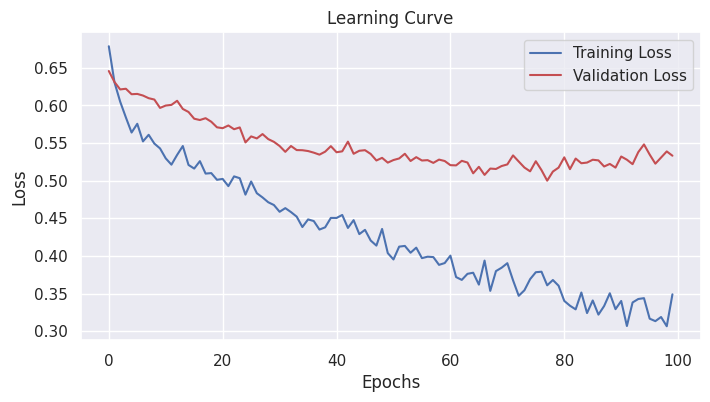

In [53]:
NN_function()

##### Selecting Features by a Threshold

In [54]:
def select_features(num, sorted_features, first_or_last='first'):
  if first_or_last == 'first':
    return sorted_features["features"][:num]
  elif first_or_last == 'last':
    return sorted_features["features"][-1*num:]

MCC score on the test set for GradientBoostingClassifier is: 0.61
MCC score on the test set for KNNClassifier is: 0.60
MCC score on the test set for LogisticRegression is: 0.52
[0.38696399331092834, 96.0, 19.0, 113.0, 24.0, 0.829365074634552, 0.834782600402832, 0.800000011920929, 0.9070075750350952, 0.9144255518913269]
MCC score on the test set for NN is: 0.66


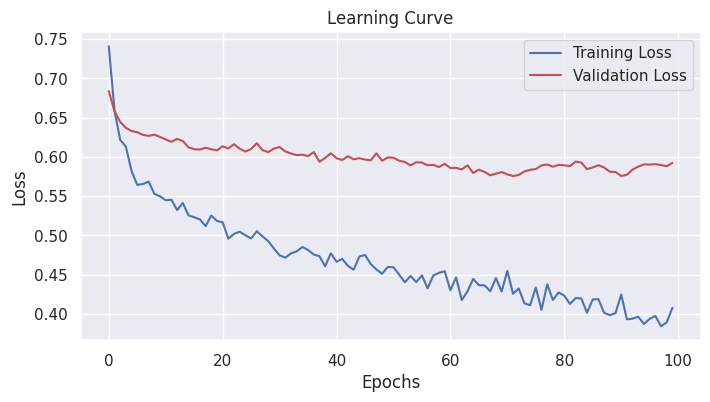

In [55]:
selected_sorted_features = select_features(15, tree_feature_selection, 'first')
GradientBoostingClassifier_function(selected_sorted_features)
KNN_function(selected_sorted_features)
LogisticRegression_function(selected_sorted_features)
NN_function(selected_sorted_features)

MCC score on the test set for GradientBoostingClassifier is: 0.49
MCC score on the test set for KNNClassifier is: 0.35
MCC score on the test set for LogisticRegression is: 0.39
[0.5945249795913696, 78.0, 32.0, 100.0, 42.0, 0.7063491940498352, 0.7090908885002136, 0.6499999761581421, 0.7531881332397461, 0.7427724599838257]
MCC score on the test set for NN is: 0.41


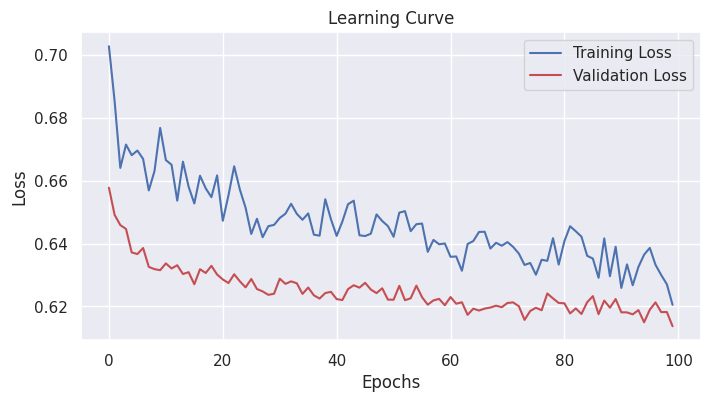

In [56]:
selected_sorted_features = select_features(15, tree_feature_selection, 'last')
GradientBoostingClassifier_function(selected_sorted_features)
KNN_function(selected_sorted_features)
LogisticRegression_function(selected_sorted_features)
NN_function(selected_sorted_features)

****** We can see that Feature Selection is so important that when we choose the less important features, the MCC drops significantly.

In [57]:
results

,Name,MCC,Selected_Features,Size
0,GradientBoosting,0.66,"[Heteroatoms, ValenceElectrons, NO, Hydrogen_B...",33
1,KNN,0.63,"[Heteroatoms, ValenceElectrons, NO, Hydrogen_B...",33
2,LogisticRegression,0.59,"[Heteroatoms, ValenceElectrons, NO, Hydrogen_B...",33
3,NeuralNet,0.71,"[Heteroatoms, ValenceElectrons, NO, Hydrogen_B...",33
4,GradientBoosting,0.61,"[Heteroatoms, ValenceElectrons, NO, Hydrogen_B...",33
5,KNN,0.60,"[Heteroatoms, ValenceElectrons, NO, Hydrogen_B...",33
6,LogisticRegression,0.52,"[Heteroatoms, ValenceElectrons, NO, Hydrogen_B...",33
7,NeuralNet,0.66,"[Heteroatoms, ValenceElectrons, NO, Hydrogen_B...",33
8,GradientBoosting,0.49,"[Heteroatoms, ValenceElectrons, NO, Hydrogen_B...",33
9,KNN,0.35,"[Heteroatoms, ValenceElectrons, NO, Hydrogen_B...",33
